<a href="https://colab.research.google.com/github/rajlm10/D2L-Torch/blob/main/D2L_NMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l

     |████████████████████████████████| 82 kB 602 kB/s 
     |████████████████████████████████| 61 kB 8.0 MB/s 
     |████████████████████████████████| 82 kB 637 kB/s 
     |████████████████████████████████| 11.6 MB 31.7 MB/s 
     |████████████████████████████████| 20.1 MB 1.3 MB/s 
     |████████████████████████████████| 9.9 MB 32.8 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency

In [2]:
import os
import torch
from d2l import torch as d2l
from torch.utils import data

# Utils

In [3]:
def grad_clipping(net, theta):
  """Clip the gradient."""
  if isinstance(net, nn.Module):
    params = [p for p in net.parameters() if p.requires_grad] 
  else:
    params = net.params
  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params)) 
  if norm > theta:
    for param in params: 
      param.grad[:] *= theta / norm

# Creating the data loader

In [4]:
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip', '94646ad1522d915e7b0f9296181140edcf86a4f5')
def read_data_nmt():
  """Load the English-French dataset."""
  data_dir = d2l.download_extract('fra-eng')
  with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
    return f.read()

raw_text = read_data_nmt() 
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



In [5]:
def preprocess_nmt(text):
  """Preprocess the English-French dataset.""" 
  def no_space(char, prev_char):
    return char in set(',.!?') and prev_char != ' '
  # Replace non-breaking space with space, and convert uppercase letters to # lowercase ones
  text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
  # Insert space between words and punctuation marks
  out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char for i, char in enumerate(text)]
  return ''.join(out)

text = preprocess_nmt(raw_text) 
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


In [6]:
def tokenize_nmt(text, num_examples=None): 
  """Tokenize the English-French dataset.""" 
  source, target = [], []
  for i, line in enumerate(text.split('\n')):
    if num_examples and i > num_examples:
       break
    parts = line.split('\t') 
    if len(parts) == 2:
      source.append(parts[0].split(' '))
      target.append(parts[1].split(' ')) 
  return source, target
  
source, target = tokenize_nmt(text) 
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

In [7]:
src_vocab = d2l.Vocab(source, min_freq=2, reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

In [8]:
def truncate_pad(line, num_steps, padding_token):
  """Truncate or pad sequences."""
  if len(line) > num_steps:
    return line[:num_steps] # Truncate
  return line + [padding_token] * (num_steps - len(line)) # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [9]:
[src_vocab[line] for line in source[:5]]

[[47, 4], [2944, 4], [435, 126], [435, 126], [90, 9]]

In [10]:
def build_array_nmt(lines,vocab,num_steps):
  """Transform text sequences of machine translation into minibatches."""
  lines = [vocab[l] for l in lines] #List of lists
  lines= [l+[vocab['<eos>']] for l in lines]
  array=torch.tensor([ truncate_pad(l,num_steps,vocab['<pad>']) for l in lines])
  valid_len=(array != vocab['<pad>']).type(torch.int32).sum(1)
  return array, valid_len #(batch_size,1)

In [11]:
def load_data_nmt(batch_size, num_steps, num_examples=600):
  """Return the iterator and the vocabularies of the translation dataset.""" 
  text = preprocess_nmt(read_data_nmt())
  source, target = tokenize_nmt(text, num_examples)
  src_vocab = d2l.Vocab(source, min_freq=2,reserved_tokens=['<pad>', '<bos>', '<eos>']) 
  tgt_vocab = d2l.Vocab(target, min_freq=2,reserved_tokens=['<pad>', '<bos>', '<eos>']) 
  src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps) 
  tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
  data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
  dataset=data.TensorDataset(*data_arrays) 
  data_iter = data.DataLoader(dataset, batch_size, shuffle=True)
  return data_iter, src_vocab, tgt_vocab

In [12]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8) 
for X, X_valid_len, Y, Y_valid_len in train_iter:
  print('X:', X.type(torch.int32),X.shape) 
  print('valid lengths for X:', X_valid_len) 
  print('Y:', Y.type(torch.int32),Y.shape) 
  print('valid lengths for Y:', Y_valid_len) 
  break

X: tensor([[93, 12,  4,  3,  1,  1,  1,  1],
        [ 7, 59,  4,  3,  1,  1,  1,  1]], dtype=torch.int32) torch.Size([2, 8])
valid lengths for X: tensor([4, 4])
Y: tensor([[  0, 103,   0, 105,   5,   3,   1,   1],
        [ 38,   7, 168,   4,   3,   1,   1,   1]], dtype=torch.int32) torch.Size([2, 8])
valid lengths for Y: tensor([6, 5])


# Encoder-Decoder Architecture 

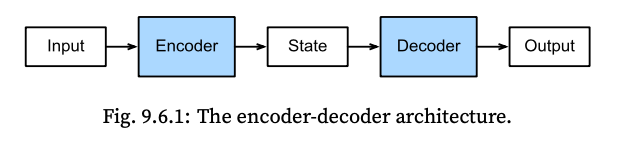

The first component is an encoder: it takes a variable-length sequence as the input and transforms it into a state with a fixed shape. The second component is a decoder: it maps the encoded state of a fixed shape to a variable-length sequence.

In [13]:
import collections
import math
from torch import nn

In [14]:
class Seq2SeqEncoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,dropout=0, **kwargs):
    super(Seq2SeqEncoder, self).__init__(**kwargs)
    # Embedding layer
    self.embedding = nn.Embedding(vocab_size, embed_size) 
    self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,dropout=dropout)

  def forward(self,X,*args):
    X = self.embedding(X) #batch_size X num_steps X embed_size
    # In RNN models, the first axis corresponds to time steps
    X = X.permute(1, 0, 2) # num_steps X batch_size  X embed_size
    output, state = self.rnn(X) 
    #output-> num_steps X batch_size X num_hiddens
    #state-> num_layers X batch_size X num_hiddens
    return output,state


In [15]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long) 
output, state = encoder(X)
output.shape,state.shape,state[-1].shape #state of uppermost gru layer in the stack

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]), torch.Size([4, 16]))

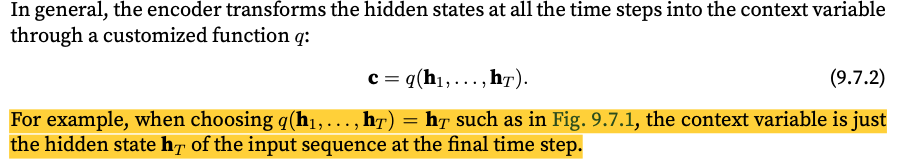

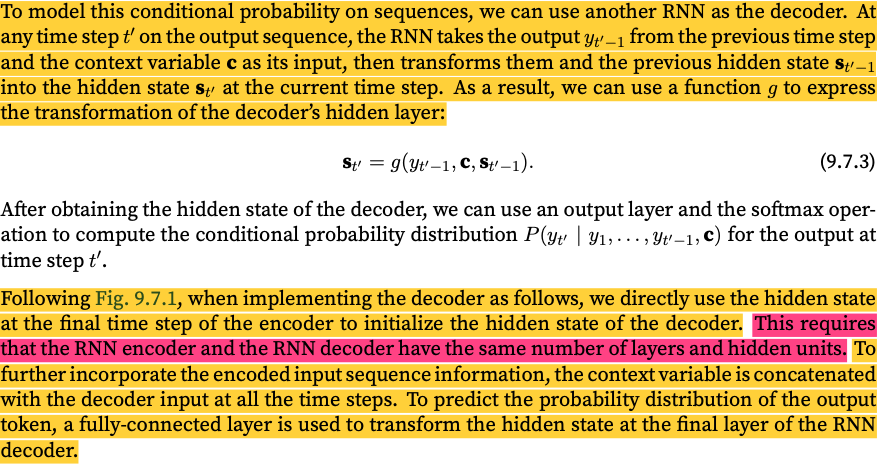

In [16]:
class Seq2SeqDecoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,dropout=0, **kwargs):
    super(Seq2SeqDecoder, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    #Note the embed_size+num_hiddens indicating the concatentation of the encoder state (batch_size X hidden_dims)
    self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,dropout=dropout)
    self.dense = nn.Linear(num_hiddens, vocab_size)

  def init_state(self, enc_outputs, *args): 
    return enc_outputs[1]

  def forward(self,X,state):
    X = self.embedding(X).permute(1, 0, 2) # num_steps X batch_size  X embed_size

    # Broadcast `context` so it has the same `num_steps` as `X` 
    context = state[-1].repeat(X.shape[0], 1, 1) #num_steps X batch_size X num_hiddens

    X_and_context = torch.cat((X, context), 2) #num_steps X batch_size X embed_size+num_hiddens

    output, state = self.rnn(X_and_context, state)
    #output-> num_steps X batch_size X num_hiddens
    #state-> num_layers X batch_size X num_hiddens

    # num_steps X batch_size X num_hiddens -> num_steps X batch_size X vocab_size -> batch_size X num_steps X vocab_size
    output = self.dense(output).permute(1, 0, 2)

    #output-> batch_size X num_steps X vocab_size
    #state-> num_layers X batch_size X num_hiddens
    return output, state



In [17]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X)) 
output, state = decoder(X, state) 
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [18]:
#Encoder Decoder
class EncoderDecoder(nn.Module):
  """The base class for the encoder-decoder architecture.""" 
  def __init__(self, encoder, decoder, **kwargs):
    super(EncoderDecoder, self).__init__(**kwargs) 
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, enc_X, dec_X, *args):
    enc_outputs = self.encoder(enc_X, *args)
    dec_state = self.decoder.init_state(enc_outputs, *args) 
    return self.decoder(dec_X, dec_state)

In [19]:
#Here is how you add dimensions wherever you want
a=torch.rand((1,5))
a.shape,a[:,:,None].shape,a[:,None,:].shape,a[None,:,:].shape

(torch.Size([1, 5]),
 torch.Size([1, 5, 1]),
 torch.Size([1, 1, 5]),
 torch.Size([1, 1, 5]))

In [20]:
a=torch.ones((5,1))
b=torch.zeros((1,2))
(b<a).shape

torch.Size([5, 2])

In [21]:
#Mask
def sequence_mask(X, valid_len, value=0):
  """Mask irrelevant entries in sequences."""
  maxlen = X.size(1)
  #Here torch.arange((maxlen)) becomes 1 X num_steps and valid_len becomes batch_size X 1
  #Comparing both after broadcasting we get batch_size X num_steps
  mask = torch.arange((maxlen), dtype=torch.float32,device=X.device)[None, :] < valid_len[:, None] 
  X[~mask] = value 
  return X #batch_size X num_steps

X = torch.tensor([[1, 2, 3], [4, 5, 6]]) 
sequence_mask(X, torch.tensor([1, 2]))



tensor([[1, 0, 0],
        [4, 5, 0]])

In [22]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
  """The softmax cross-entropy loss with masks."""
  # `pred` shape: (`batch_size`, `num_steps`, `vocab_size`) 
  # `label` shape: (`batch_size`, `num_steps`)
  # `valid_len` shape: (`batch_size`,)
  def forward(self, pred, label, valid_len):
    weights = torch.ones_like(label) #batch_size X num_steps
    weights = sequence_mask(weights, valid_len) #batch_size X num_steps
    self.reduction='none'
    #y_hat-> batch_size X vocab_size X num_steps, y-> batch_size X num_steps
    #Output-> batch_size X num_steps (since reduction=='none')
    unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label) 
    weighted_loss = (unweighted_loss * weights).mean(dim=1) #batch_size
    return weighted_loss

In [23]:
def train_seq2seq(net, data_iter,loss,optimizer, num_epochs, target_vocab, device):
  def xavier_init_weights(m):
    if type(m) == nn.Linear: 
      nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.GRU:
      for param in m._flat_weights_names:
        if "weight" in param: 
          nn.init.xavier_uniform_(m._parameters[param])
  net.apply(xavier_init_weights)
  net.to(device)
  net.train()
  for epoch in range(num_epochs):
    timer = d2l.Timer()
    metric = d2l.Accumulator(2) # Sum of training loss, no of unmasked tokens
    for batch in data_iter:
      optimizer.zero_grad()
      X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
      bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],device=device).reshape(-1, 1) # batch_size X 1

      #Y-> batch_size X num_steps
      #dec_input-> batch_size X num_steps (add bos omit eos)
      dec_input = torch.cat([bos, Y[:, :-1]], 1) # Teacher forcing

      Y_hat, _ = net(X, dec_input, X_valid_len)
      l = loss(Y_hat, Y, Y_valid_len)
      #Sum along entire batch
      l.sum().backward() # Make the loss scalar for `backward`
      grad_clipping(net, 1)
      num_tokens = Y_valid_len.sum() #Note how we consider UNMASKED tokens only
      optimizer.step()
      with torch.no_grad():
        metric.add(l.sum(), num_tokens)

    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} ' f'tokens/sec on {str(device)}')



In [24]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1 

batch_size, num_steps = 64, 10

lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab =load_data_nmt(batch_size, num_steps)


encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

net = EncoderDecoder(encoder, decoder)

loss=MaskedSoftmaxCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


In [25]:
train_seq2seq(net, train_iter, loss,optimizer,num_epochs, tgt_vocab, device)


loss 0.456, 7198.0 tokens/sec on cuda:0
loss 0.331, 14767.9 tokens/sec on cuda:0
loss 0.302, 14393.6 tokens/sec on cuda:0
loss 0.283, 14212.7 tokens/sec on cuda:0
loss 0.267, 14382.6 tokens/sec on cuda:0
loss 0.253, 14831.8 tokens/sec on cuda:0
loss 0.241, 14867.7 tokens/sec on cuda:0
loss 0.230, 14803.0 tokens/sec on cuda:0
loss 0.219, 13971.5 tokens/sec on cuda:0
loss 0.210, 14527.5 tokens/sec on cuda:0
loss 0.202, 14565.8 tokens/sec on cuda:0
loss 0.195, 14891.4 tokens/sec on cuda:0
loss 0.188, 14673.1 tokens/sec on cuda:0
loss 0.182, 14716.8 tokens/sec on cuda:0
loss 0.176, 14479.3 tokens/sec on cuda:0
loss 0.169, 14806.8 tokens/sec on cuda:0
loss 0.163, 14706.2 tokens/sec on cuda:0
loss 0.157, 14972.2 tokens/sec on cuda:0
loss 0.152, 14488.0 tokens/sec on cuda:0
loss 0.146, 15059.7 tokens/sec on cuda:0
loss 0.141, 13882.0 tokens/sec on cuda:0
loss 0.137, 14762.3 tokens/sec on cuda:0
loss 0.131, 14334.1 tokens/sec on cuda:0
loss 0.127, 14848.9 tokens/sec on cuda:0
loss 0.122, 14470

# Predictions

To predict the output sequence token by token, at each decoder time step the predicted token from the previous time step is fed into the decoder as an input. Similar to training, at the initial time step the beginning-of-sequence bos token is fed into the decoder.

- Tokenize prompt and add a eos token
- Find the len of the prompt including this eos token
- Truncate or pad the prompt tokens upto num_steps
- Add a batch axis and pass to encoder
- Receive the encoder output and get the decoder initial state
- Initialize a bos token and add batch axis
- For num steps pass a token t and the decoder inital state to the decoder to get a prediction p and store it in a list
- Set t to p until loop ends or we encounter the eos token
- Join the output tokens in the list

In [26]:
def predict_seq2seq(net, prompt, source_vocab, target_vocab, num_steps, device):
  net.eval()
  prompt_tokens = source_vocab[prompt.lower().split(' ')] + [source_vocab['<eos>']]
  enc_valid_len = torch.tensor([len(prompt_tokens)], device=device)
  prompt_tokens = truncate_pad(prompt_tokens, num_steps, source_vocab['<pad>'])
  #Add batch axis
  enc_X=torch.tensor(prompt_tokens, dtype=torch.long, device=device)[None,:]
  enc_outputs = net.encoder(enc_X, enc_valid_len)
  dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)

  dec_X=torch.tensor([target_vocab['<bos>']], dtype=torch.long, device=device)[None,:]
  output_seq=[]

  for _ in range(num_steps):
    Y, dec_state = net.decoder(dec_X, dec_state)
    dec_X=Y.argmax(dim=-1)
    pred = dec_X[0].type(torch.int32).item()
    if pred == target_vocab['<eos>']:
      break
    output_seq.append(pred)
  return ' '.join(target_vocab.to_tokens(output_seq))

In [27]:
predict_seq2seq(net,'Hi there',src_vocab,tgt_vocab,10,device)

'salut !'

# BLEU 
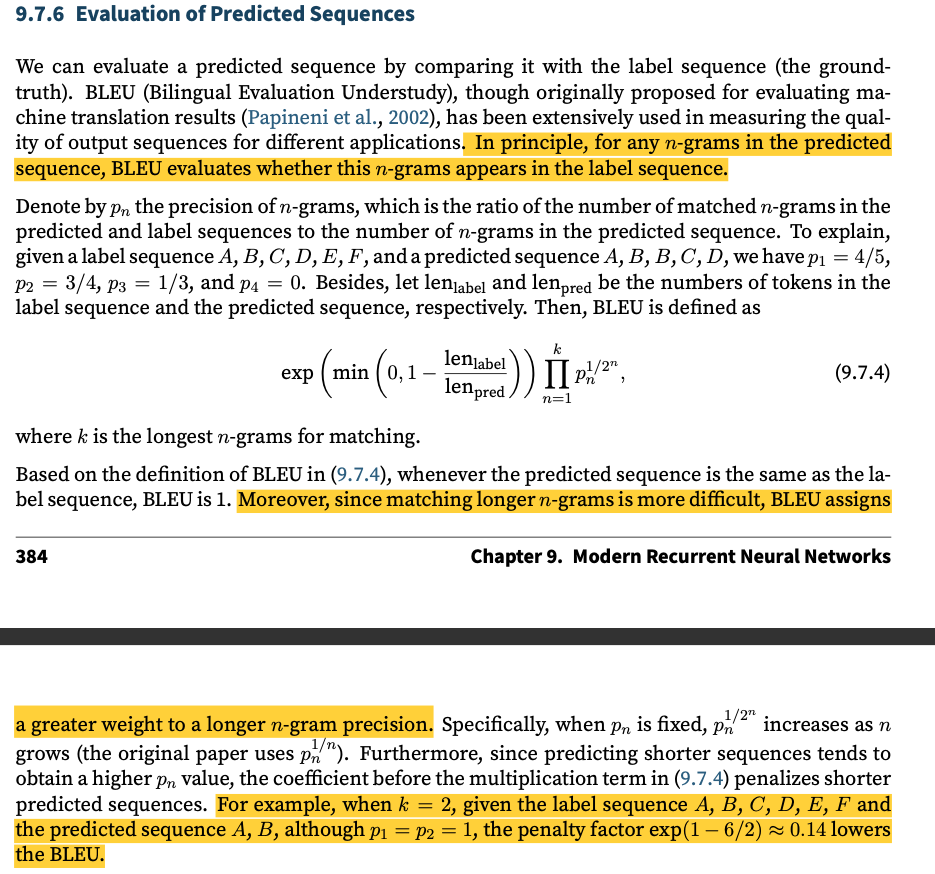

In [28]:
def bleu(pred_seq, label_seq, k):
  """Compute the BLEU."""
  pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ') 
  len_pred, len_label = len(pred_tokens), len(label_tokens)
  score = math.exp(min(0, 1 - len_label / len_pred))
  for n in range(1, k + 1):
    num_matches, label_subs = 0, collections.defaultdict(int) 
    for i in range(len_label - n + 1):
      label_subs[' '.join(label_tokens[i: i + n])] += 1 
    for i in range(len_pred - n + 1):
      if label_subs[' '.join(pred_tokens[i: i + n])] > 0: 
        num_matches += 1
        label_subs[' '.join(pred_tokens[i: i + n])] -= 1 #Since we can have multiple occurences of the n-gram hence we count each unique match
    score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n)) 
  return score

In [29]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .'] 

for eng, fra in zip(engs, fras):
  translation = predict_seq2seq( net, eng, src_vocab, tgt_vocab, num_steps, device)
  print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va au payé ., bleu 0.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est bon triste ?, bleu 0.447
i'm home . => je suis chez moi chez ., bleu 0.803


# LSTM based seq2seq 

In [30]:
class Seq2SeqEncoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,dropout=0, **kwargs):
    super(Seq2SeqEncoder, self).__init__(**kwargs)
    # Embedding layer
    self.embedding = nn.Embedding(vocab_size, embed_size) 
    self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers,dropout=dropout)

  def forward(self,X,*args):
    X = self.embedding(X) #batch_size X num_steps X embed_size
    # In RNN models, the first axis corresponds to time steps
    X = X.permute(1, 0, 2) # num_steps X batch_size  X embed_size
    output, state = self.rnn(X) 
    #output-> num_steps X batch_size X num_hiddens
    #state-> (hn->num_layers X batch_size X num_hiddens,cn->num_layers X batch_size X num_hiddens)
    return output,state


In [32]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long) 
output, state = encoder(X)
output.shape,state[0].shape,state[1].shape

(torch.Size([7, 4, 16]), torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

In [33]:
state[0][-1].shape

torch.Size([4, 16])

In [34]:
class Seq2SeqDecoder(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,dropout=0, **kwargs):
    super(Seq2SeqDecoder, self).__init__(**kwargs)
    self.embedding = nn.Embedding(vocab_size, embed_size)
    #Note the embed_size+num_hiddens indicating the concatentation of the encoder state (batch_size X hidden_dims)
    self.rnn = nn.LSTM(embed_size + 2*num_hiddens, num_hiddens, num_layers,dropout=dropout)
    self.dense = nn.Linear(num_hiddens, vocab_size)

  def init_state(self, enc_outputs, *args): 
    return enc_outputs[1]

  def forward(self,X,state):
    X = self.embedding(X).permute(1, 0, 2) # num_steps X batch_size  X embed_size

    # Broadcast `context` so it has the same `num_steps` as `X` 
    context_hn = state[0][-1].repeat(X.shape[0], 1, 1) #num_steps X batch_size X num_hiddens
    context_cn = state[0][-1].repeat(X.shape[0], 1, 1) #num_steps X batch_size X num_hiddens

    X_and_context = torch.cat((X, context_hn,context_cn), 2) #num_steps X batch_size X embed_size+2*num_hiddens

    output, state = self.rnn(X_and_context, state)
    #output-> num_steps X batch_size X num_hiddens
    #state-> (hn->num_layers X batch_size X num_hiddens,cn->num_layers X batch_size X num_hiddens)

    # num_steps X batch_size X num_hiddens -> num_steps X batch_size X vocab_size -> batch_size X num_steps X vocab_size
    output = self.dense(output).permute(1, 0, 2)

    #output-> batch_size X num_steps X vocab_size
    #state-> (hn->num_layers X batch_size X num_hiddens,cn->num_layers X batch_size X num_hiddens)
    return output, state



In [36]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X)) 
output, state = decoder(X, state) 
output.shape, state[0].shape,state[1].shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

In [37]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1 

batch_size, num_steps = 64, 10

lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab =load_data_nmt(batch_size, num_steps)


encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)

net = EncoderDecoder(encoder, decoder)

loss=MaskedSoftmaxCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


In [38]:
train_seq2seq(net, train_iter, loss,optimizer,num_epochs, tgt_vocab, device)


loss 0.490, 13882.5 tokens/sec on cuda:0
loss 0.357, 14386.0 tokens/sec on cuda:0
loss 0.303, 14216.8 tokens/sec on cuda:0
loss 0.287, 14362.2 tokens/sec on cuda:0
loss 0.275, 13842.6 tokens/sec on cuda:0
loss 0.262, 14569.3 tokens/sec on cuda:0
loss 0.250, 13851.2 tokens/sec on cuda:0
loss 0.241, 14474.8 tokens/sec on cuda:0
loss 0.233, 13669.9 tokens/sec on cuda:0
loss 0.226, 13816.7 tokens/sec on cuda:0
loss 0.221, 14336.8 tokens/sec on cuda:0
loss 0.215, 14118.3 tokens/sec on cuda:0
loss 0.209, 14464.6 tokens/sec on cuda:0
loss 0.205, 14161.7 tokens/sec on cuda:0
loss 0.200, 14325.1 tokens/sec on cuda:0
loss 0.195, 13943.1 tokens/sec on cuda:0
loss 0.189, 14141.1 tokens/sec on cuda:0
loss 0.184, 14188.0 tokens/sec on cuda:0
loss 0.179, 14357.2 tokens/sec on cuda:0
loss 0.175, 14342.7 tokens/sec on cuda:0
loss 0.171, 13892.8 tokens/sec on cuda:0
loss 0.167, 14275.1 tokens/sec on cuda:0
loss 0.163, 13927.2 tokens/sec on cuda:0
loss 0.159, 13833.4 tokens/sec on cuda:0
loss 0.156, 1378

In [39]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .'] 

for eng, fra in zip(engs, fras):
  translation = predict_seq2seq( net, eng, src_vocab, tgt_vocab, num_steps, device)
  print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est <unk> tomber ., bleu 0.548
i'm home . => je suis chez moi ., bleu 1.000
